In [1]:
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.AE_Generation import AutoEncoder
from traffic.algorithms.generation import Generation

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [9]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="linear",
    # shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

test = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_test.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    # scaler=MinMaxScaler(feature_range=(-1,1)),
    scaler=dataset.scaler,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [10]:
path = "../../deep_traffic_generation/lightning_logs/fcae/version_3/"

t = AutoEncoder(X = dataset, AE_type="FCAE")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.AE.hparams.features, scaler=dataset.scaler) 

# Latent Space

Explained variance ratio :  [0.29195163 0.12578498]


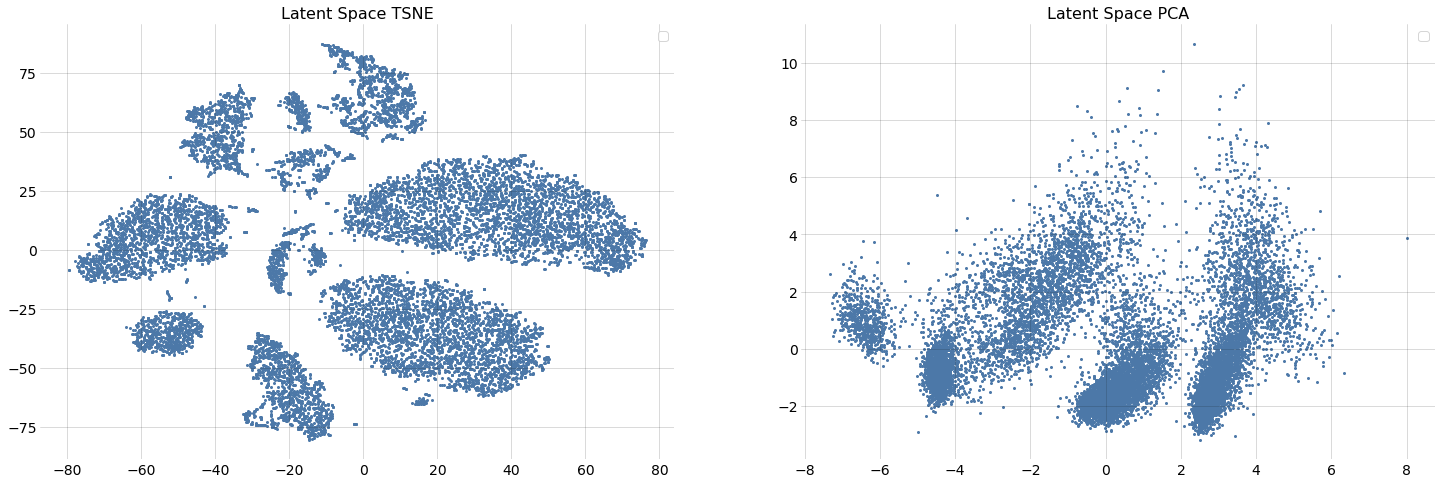

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Z = t.latent_space()

Z_embedded1 = TSNE(n_components=2).fit_transform(Z)

pca = PCA(n_components=2).fit(Z)
Z_embedded2 = pca.transform(Z)
print("Explained variance ratio : ", pca.explained_variance_ratio_)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1,2, figsize=(25, 8))

    ax[0].scatter(Z_embedded1[:,0], Z_embedded1[:,1], s=4)
    ax[0].title.set_text("Latent Space TSNE")
    ax[0].legend()

    ax[1].scatter(Z_embedded2[:,0], Z_embedded2[:,1], s=4)
    ax[1].title.set_text("Latent Space PCA")
    ax[1].legend()

    plt.show()

Explained variance ratio :  [0.43426365 0.12906002]
Clustering done
traffic :  0
traffic :  1
traffic :  2
traffic :  3


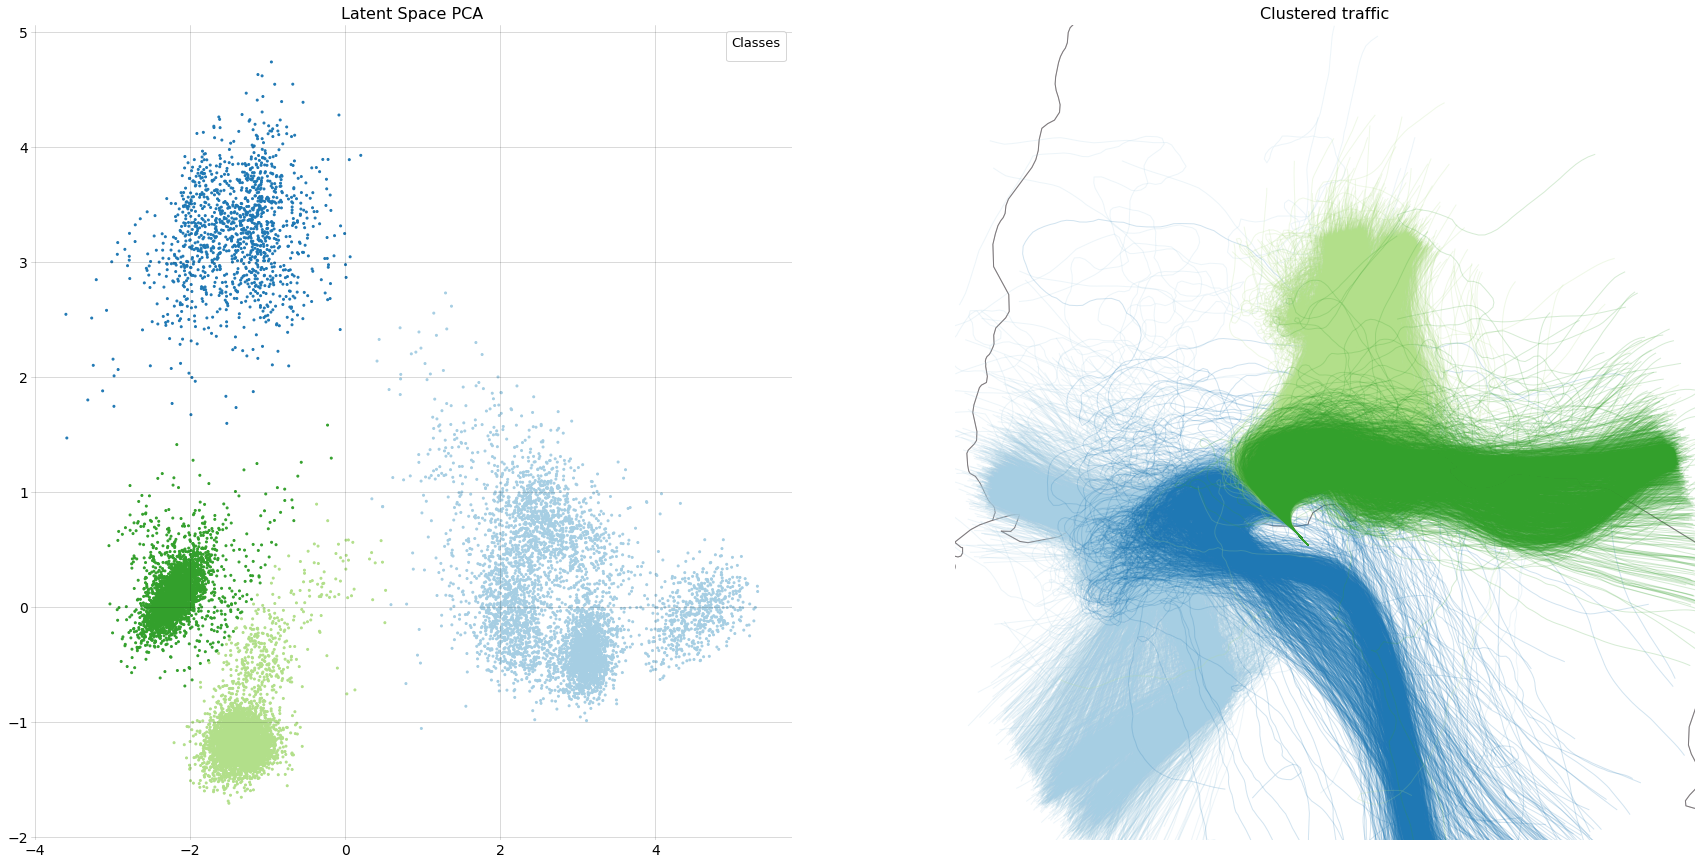

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from traffic.core.projection import EuroPP
from traffic.drawing import countries

Z = t.latent_space()

pca = PCA(n_components=2).fit(Z)
Z_embedded = pca.transform(Z)
# Z_embedded = TSNE(n_components=2).fit_transform(Z)
print("Explained variance ratio : ", pca.explained_variance_ratio_)

#Clustering on the pca transformation (too long directly on Z)
cluster = SpectralClustering(n_clusters=4, gamma = 8.0).fit_predict(Z_embedded)
# cluster = KMeans(n_clusters=6, random_state=0).fit(Z_embedded)
# cluster = DBSCAN(eps=0.2, min_samples=10).fit(Z_embedded)
# cluster = GaussianMixture(n_components=7, random_state=0).fit_predict(Z)
print("Clustering done")

labels = cluster
# labels = cluster.labels_

traffics = []
for i in np.unique(labels):
    print("traffic : ", i)
    decoded = t.decode(torch.Tensor(Z[labels== i]))
    traffics.append(g.build_traffic(decoded, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False))


color_cycle = "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c #fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
colors = [color_cycle[i] for i in labels]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 15))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122, projection=EuroPP())
    

    scat1 = ax0.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s=4, c = colors)
    ax0.title.set_text("Latent Space PCA")
    legend1 = ax0.legend(*scat1.legend_elements(),
                    loc="upper right", title="Classes")

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Clustered traffic")
    for i, traf in enumerate(traffics) :
        traf.plot(ax1, alpha=0.2, color = color_cycle[i])

    plt.show()

# Reconstruction

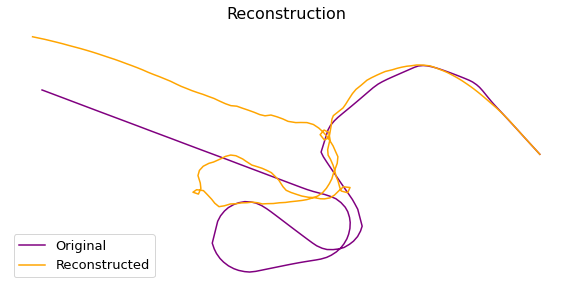

In [12]:
from traffic.core.projection import EuroPP
from traffic.drawing import countries
import matplotlib.pyplot as plt

#Comparison of a trajectory and it's reconstructed counterpart

# j = np.random.randint(len(dataset.data))
j = 10795

original = dataset.data[j].unsqueeze(0)
if len(original.shape) >= 3:
    original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

reconstructed = t.decode(t.AE.encoder(dataset.data[j].unsqueeze(0)))
reconstructed_traf = g.build_traffic(reconstructed, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    ax.set_title("Reconstruction")
    original_traf.plot(ax, c="purple", label="Original")
    reconstructed_traf.plot(ax, c="orange", label = "Reconstructed")
    plt.legend()

    plt.show()

In [ ]:
#Trajectories interesting to compare : j = 10519, 10795, 12104, 9811, 6260

# Sampling within Latent Space

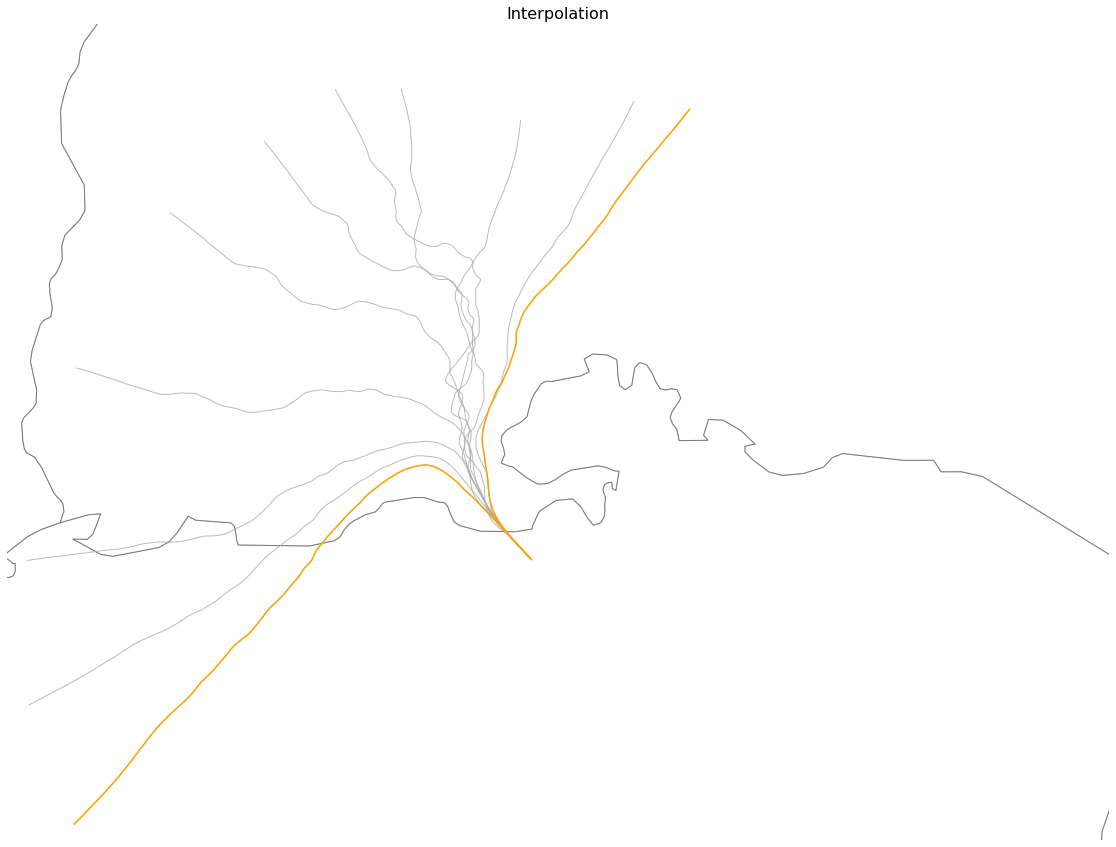

In [14]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries

Z = t.latent_space()
js = np.random.randint(len(Z), size = 2)
n_gen = 10
inter = []

for n in range(1,n_gen):
    inter.append(((n_gen-n)/n_gen)*torch.Tensor(Z[js[0]]) + (n/n_gen)*torch.Tensor(Z[js[1]]))
inter = torch.stack(inter)
gen = torch.cat((inter, torch.Tensor(Z[js])), axis=0)

out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(111, projection=EuroPP())
    
    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47.2, 48.2))
    ax.title.set_text("Interpolation")
    out_traf.plot(ax)
    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax, color = "orange")
    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax, color = "orange")

    plt.show()

In [19]:
#estimation of the distribution with copulas
import pyvinecopulib as pv

Z = t.latent_space()

u = pv.to_pseudo_obs(Z)
controls = pv.FitControlsVinecop(
    num_threads=4,
)
vine = pv.Vinecop(data=u, controls=controls)

In [ ]:
u_sim = vine.simulate(n=100, seeds=[42])